# A First Attempt Using Multiple Linear Regression
## Author:                Ian Kinskey
## Created:              April 30, 2017

For Kaggle competition "House Prices: Advanced Regression Techniques":  https://goo.gl/hKF6Iv

[Data Descriptions](data_description.txt)

---

## Process

We're going to build a tentative model with little upfront analysis via the following process:
* explore correlations in features
* exploit strongest correlations with SalePrice
* sprinkle in some human intuition
* automate variable selection via stepAIC from MASS package

---

## Housekeeping

Load some libraries

In [2]:
library("MASS")
library("corrplot")
library("mosaic")

Loading required package: dplyr

Attaching package: ‘dplyr’

The following object is masked from ‘package:MASS’:

    select

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Loading required package: ggplot2
Loading required package: mosaicData
Loading required package: Matrix

The 'mosaic' package masks several functions from core packages in order to add additional features.  
The original behavior of these functions should not be affected by this.

Attaching package: ‘mosaic’

The following object is masked from ‘package:Matrix’:

    mean

The following objects are masked from ‘package:dplyr’:

    count, do, tally

The following objects are masked from ‘package:stats’:

    binom.test, cor, cov, D, fivenum, IQR, median, prop.test, quantile,
    sd, t.test, var

The following objects are masked from ‘package:base’:

    max, mean

Load the data

In [3]:
housing <- read.csv("train.csv")
attach(housing)

The following object is masked from package:mosaicData:

    Utilities



---
## Exploratory Data Analysis

What are dimenions of data?

In [4]:
dim(housing)

[1] 1460   81

There are 80 variables (excluding the Y:  SalePrice), and 1,460 observations.

In [5]:
str(housing)

'data.frame':	1460 obs. of  81 variables:
 $ Id           : int  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : int  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : int  65 80 68 60 84 85 75 NA 51 50 ...
 $ LotArea      : int  8450 9600 11250 9550 14260 14115 10084 10382 6120 7420 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ Alley        : Factor w/ 2 levels "Grvl","Pave": NA NA NA NA NA NA NA NA NA NA ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..:

How many columns contain NAs?

In [6]:
na.cols = which(colSums(is.na(housing)) > 0)
sort(colSums(sapply(housing[na.cols], is.na)), decreasing = TRUE)

PoolQC  MiscFeature        Alley        Fence  FireplaceQu  LotFrontage 
        1453         1406         1369         1179          690          259 
  GarageType  GarageYrBlt GarageFinish   GarageQual   GarageCond BsmtExposure 
          81           81           81           81           81           38 
BsmtFinType2     BsmtQual     BsmtCond BsmtFinType1   MasVnrType   MasVnrArea 
          38           37           37           37            8            8 
  Electrical 
           1

For better or worse, we are going to ignore all of these columns, though some of them may be predictive.

In [52]:
drop <- c('Alley','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtQual','Electrical'
          ,'Fence','FireplaceQu','GarageCond','GarageFinish','GarageQual','GarageType','GarageYrBlt'
          ,'LotFrontage','MasVnrArea','MasVnrType','MiscFeature','PoolQC')

housing2 <- housing[ , !(names(housing) %in% drop)]
dim(housing2)
housing2 <- na.omit(housing2)

[1] 1460   62

Now let's take a look at the correlations for numeric variables.

In [57]:
numeric_var <- names(housing2)[which(sapply(housing2, is.numeric))]
df.numeric <- housing2[, names(housing2) %in% numeric_var]

In [58]:
# need the SalePrice column
correlations = cor(df.numeric)

In [59]:
corr.SalePrice = as.matrix(sort(correlations[,'SalePrice'], decreasing = TRUE))

In [63]:
corr.idx = names(which(apply(corr.SalePrice, 1, function(x) (x > 0.5 | x < -0.5))))

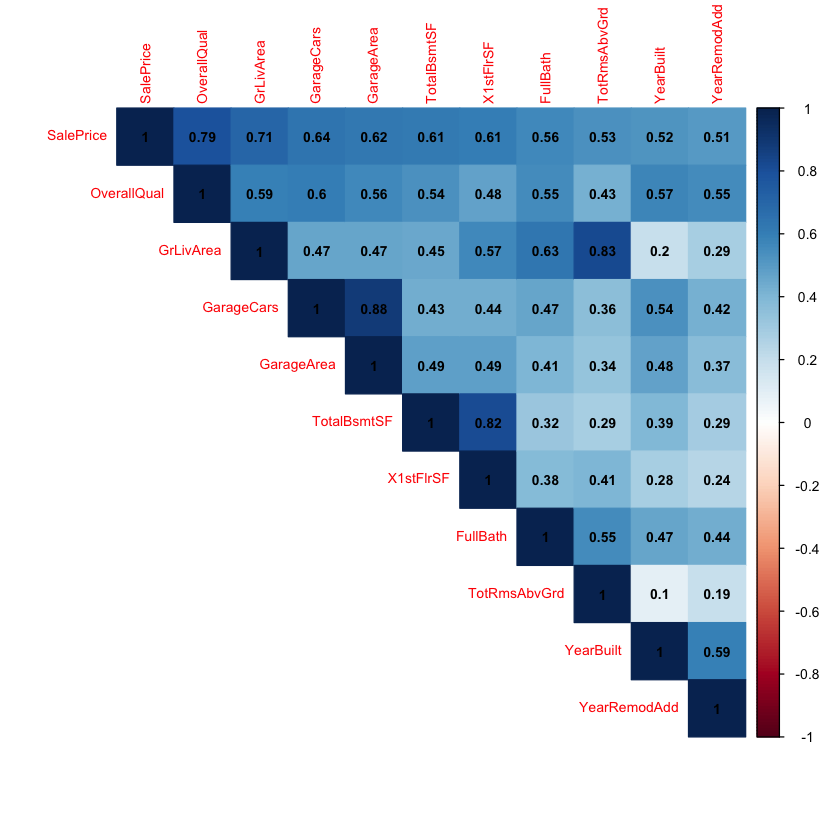

In [64]:
corrplot(as.matrix(correlations[corr.idx,corr.idx]), type = 'upper', method='color', addCoef.col = 'black', tl.cex = .7,cl.cex = .7, number.cex=.7)

In [66]:
keep.names <- corr.idx

In [67]:
cat_var <- setdiff(names(housing2),numeric_var)
cat_var
numeric_var
c(keep.names, cat_var)

[1] "MSZoning"      "Street"        "LotShape"      "LandContour"  
 [5] "Utilities"     "LotConfig"     "LandSlope"     "Neighborhood" 
 [9] "Condition1"    "Condition2"    "BldgType"      "HouseStyle"   
[13] "RoofStyle"     "RoofMatl"      "Exterior1st"   "Exterior2nd"  
[17] "ExterQual"     "ExterCond"     "Foundation"    "Heating"      
[21] "HeatingQC"     "CentralAir"    "KitchenQual"   "Functional"   
[25] "PavedDrive"    "SaleType"      "SaleCondition"

[1] "Id"            "MSSubClass"    "LotArea"       "OverallQual"  
 [5] "OverallCond"   "YearBuilt"     "YearRemodAdd"  "BsmtFinSF1"   
 [9] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "X1stFlrSF"    
[13] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[17] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[21] "KitchenAbvGr"  "TotRmsAbvGrd"  "Fireplaces"    "GarageCars"   
[25] "GarageArea"    "WoodDeckSF"    "OpenPorchSF"   "EnclosedPorch"
[29] "X3SsnPorch"    "ScreenPorch"   "PoolArea"      "MiscVal"      
[33] "MoSold"        "YrSold"        "SalePrice"

[1] "SalePrice"     "OverallQual"   "GrLivArea"     "GarageCars"   
 [5] "GarageArea"    "TotalBsmtSF"   "X1stFlrSF"     "FullBath"     
 [9] "TotRmsAbvGrd"  "YearBuilt"     "YearRemodAdd"  "MSZoning"     
[13] "Street"        "LotShape"      "LandContour"   "Utilities"    
[17] "LotConfig"     "LandSlope"     "Neighborhood"  "Condition1"   
[21] "Condition2"    "BldgType"      "HouseStyle"    "RoofStyle"    
[25] "RoofMatl"      "Exterior1st"   "Exterior2nd"   "ExterQual"    
[29] "ExterCond"     "Foundation"    "Heating"       "HeatingQC"    
[33] "CentralAir"    "KitchenQual"   "Functional"    "PavedDrive"   
[37] "SaleType"      "SaleCondition"

Fudge it!  Let's just build a freaking starting model for stepwise to evaluate!:

In [68]:
fit <- lm(SalePrice~ BldgType + CentralAir + Condition1 + Condition2 + ExterCond + Exterior1st + Exterior2nd + ExterQual + Foundation + FullBath + Functional + GarageArea + GarageCars + GrLivArea + Heating + HeatingQC + HouseStyle + KitchenQual + LandContour + LandSlope + LotConfig + LotShape + MSZoning + Neighborhood + OverallQual + PavedDrive + RoofMatl + RoofStyle + SaleCondition + SaleType + Street + TotalBsmtSF + TotRmsAbvGrd + Utilities + X1stFlrSF + YearBuilt + YearRemodAdd,data=housing2)

In [69]:
step <- stepAIC(fit, direction="both")
step$anova # display results
summary(step)

Start:  AIC=29924.36
SalePrice ~ BldgType + CentralAir + Condition1 + Condition2 + 
    ExterCond + Exterior1st + Exterior2nd + ExterQual + Foundation + 
    FullBath + Functional + GarageArea + GarageCars + GrLivArea + 
    Heating + HeatingQC + HouseStyle + KitchenQual + LandContour + 
    LandSlope + LotConfig + LotShape + MSZoning + Neighborhood + 
    OverallQual + PavedDrive + RoofMatl + RoofStyle + SaleCondition + 
    SaleType + Street + TotalBsmtSF + TotRmsAbvGrd + Utilities + 
    X1stFlrSF + YearBuilt + YearRemodAdd

                Df  Sum of Sq        RSS   AIC
- Exterior2nd   14 1.4275e+10 9.4228e+11 29919
- ExterCond      4 1.5718e+09 9.2958e+11 29919
- PavedDrive     2 2.9919e+08 9.2830e+11 29921
- RoofStyle      5 4.8097e+09 9.3281e+11 29922
- Heating        5 5.2129e+09 9.3322e+11 29922
- FullBath       1 4.2268e+08 9.2843e+11 29923
- CentralAir     1 4.6655e+08 9.2847e+11 29923
- HeatingQC      4 4.3617e+09 9.3237e+11 29923
- Foundation     5 5.6513e+09 9.3366e+11 29

Step,Df,Deviance,Resid. Df,Resid. Dev,AIC
,NA,NA,1295,928004423031,29924.36
- Exterior2nd,14,14275477365,1309,942279900396,29918.65
- Exterior1st,14,10264286922,1323,952544187318,29906.47
- ExterCond,4,1798215158,1327,954342402476,29901.22
- PavedDrive,2,217564490,1329,954559966966,29897.55
- Foundation,5,5182661935,1334,959742628901,29895.46
- FullBath,1,305485963,1335,960048114864,29893.92
- Utilities,1,517402684,1336,960565517548,29892.71
- GarageCars,1,700565313,1337,961266082862,29891.78
- Street,1,745032920,1338,962011115782,29890.91



Call:
lm(formula = SalePrice ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    TotRmsAbvGrd + YearBuilt + YearRemodAdd, data = housing2)

Residuals:
    Min      1Q  Median      3Q     Max 
-166591  -12966       0   11866  216022 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.522e+06  1.632e+05  -9.328  < 2e-16 ***
BldgType2fmCon       -4.882e+03  5.618e+03  -0.869 0.384976    
BldgTypeDuplex       -2.504e+04  4.834e+03  -5.180 2.56e-07 ***
BldgTypeTwnhs        -2.855e+04  5.916e+03  -4.826 1.55e-06 ***
BldgTypeTwnhsE       -2.420e+04  3.964e+03  -6.105 1.35e-09 ***
CentralAirY           5.678e+03  3.943e+03   1.440 0.150172    
Condition1Feedr       2.171e+03  5.493

In [70]:
summary(step)


Call:
lm(formula = SalePrice ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    TotRmsAbvGrd + YearBuilt + YearRemodAdd, data = housing2)

Residuals:
    Min      1Q  Median      3Q     Max 
-166591  -12966       0   11866  216022 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -1.522e+06  1.632e+05  -9.328  < 2e-16 ***
BldgType2fmCon       -4.882e+03  5.618e+03  -0.869 0.384976    
BldgTypeDuplex       -2.504e+04  4.834e+03  -5.180 2.56e-07 ***
BldgTypeTwnhs        -2.855e+04  5.916e+03  -4.826 1.55e-06 ***
BldgTypeTwnhsE       -2.420e+04  3.964e+03  -6.105 1.35e-09 ***
CentralAirY           5.678e+03  3.943e+03   1.440 0.150172    
Condition1Feedr       2.171e+03  5.493

In [73]:
lm2 <- lm(formula = log(SalePrice) ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    TotRmsAbvGrd + YearBuilt + YearRemodAdd, data = housing2)

In [75]:
summary(lm2)


Call:
lm(formula = log(SalePrice) ~ BldgType + CentralAir + Condition1 + 
    Condition2 + ExterQual + Functional + GarageArea + GrLivArea + 
    Heating + HouseStyle + KitchenQual + LandContour + LandSlope + 
    LotConfig + LotShape + MSZoning + Neighborhood + OverallQual + 
    RoofMatl + RoofStyle + SaleCondition + SaleType + TotalBsmtSF + 
    TotRmsAbvGrd + YearBuilt + YearRemodAdd, data = housing2)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70666 -0.06139  0.00375  0.06655  0.68681 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           1.431e+00  7.395e-01   1.935 0.053236 .  
BldgType2fmCon        2.509e-02  2.546e-02   0.986 0.324540    
BldgTypeDuplex       -9.637e-02  2.191e-02  -4.399 1.17e-05 ***
BldgTypeTwnhs        -1.021e-01  2.681e-02  -3.809 0.000146 ***
BldgTypeTwnhsE       -5.197e-02  1.796e-02  -2.893 0.003876 ** 
CentralAirY           1.262e-01  1.787e-02   7.061 2.64e-12 ***
Condition1Feedr       2

In [76]:
test <- read.csv("test.csv")

In [88]:
test[x,c('BldgType', 'CentralAir', 'Condition1', 'Condition2', 'ExterQual', 'Functional', 'GarageArea', 'GrLivArea', 'Heating', 'HouseStyle', 'KitchenQual','LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'Neighborhood', 'OverallQual', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'TotalBsmtSF', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd')]

,BldgType,CentralAir,Condition1,Condition2,ExterQual,Functional,GarageArea,GrLivArea,Heating,HouseStyle,⋯,Neighborhood,OverallQual,RoofMatl,RoofStyle,SaleCondition,SaleType,TotalBsmtSF,TotRmsAbvGrd,YearBuilt,YearRemodAdd
2,1Fam,Y,Norm,Norm,TA,Typ,312,1329,GasA,1Story,⋯,NAmes,6,CompShg,Hip,Normal,WD,1329,6,1958,1958


In [109]:
# for (idx in 1:dim(test)[1]){
#   print(idx)
# }

z <- data.frame(predict(lm2, test[,c('BldgType', 'CentralAir', 'Condition1', 'Condition2', 'ExterQual', 'Functional', 'GarageArea', 'GrLivArea', 'Heating', 'HouseStyle', 'KitchenQual','LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning', 'Neighborhood', 'OverallQual', 'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'TotalBsmtSF', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd')]))


In [113]:
colnames(z) <- "log.predict"

In [114]:
z$predict <- exp(z$log.predict)

In [116]:
z$predict

[1]  122579.30  158622.71  170799.49  182971.44  210258.58  175706.57
   [7]  164027.93  166044.39  185332.93  122800.49  180710.56   98841.00
  [13]   99309.72  145352.90  122862.65  394116.14  277437.36  313696.18
  [19]  312759.43  564051.85  317513.15  215740.56  184785.64  167204.79
  [25]  176463.55  200903.32  372379.68  247731.37  210917.09  205549.50
  [31]  196977.79   96088.88  162879.25  289986.21  282490.03  213811.63
  [37]  199903.28  181116.54  157546.98  150952.65  172922.55  156462.55
  [43]  256152.13  234673.91  217329.20  201256.56  250026.24  199288.23
  [49]  159277.39  147162.84  162121.94  168108.55  150180.55  153934.77
  [55]  193403.34  141639.86  163414.61  147446.87  214515.60  134351.50
  [61]  138046.24  163302.02  124731.68  118725.58  122571.00  114994.29
  [67]  119567.94  134434.74  141158.66  170709.79  101818.62   89992.62
  [73]  147158.72  127391.04  137424.69  108391.11   75412.72  138862.12
  [79]  181242.04   92683.91  132556.12  148305.94  182493.43   83550.25
  [85]  111439.17  131444.00  120829.49  138147.25  124873.36  138639.32
  [91]  107788.69  134417.88  131333.68  120792.75  164068.12         NA
  [97]  118281.40  107713.39   73745.42  133619.77  108106.16  136454.97
 [103]  121221.20  155108.41  142330.55  230479.21   85580.88  239097.46
 [109]  128181.67  131262.25  119976.09  134710.75  217863.78  144351.75
 [115]  204478.79  222410.72  190905.61  141446.51  150350.40  190344.32
 [121]  134488.60  124548.99  287167.90  226851.71  133803.73   80664.48
 [127]  105249.56  136703.06   88731.80  141135.49  104902.69  108657.27
 [133]  124476.19  139030.77  128265.67  245934.17  196473.20  223052.88
 [139]  176746.02  187343.16   82598.98  124538.13   63370.99  264940.32
 [145]  232121.38  165646.43  223679.02  216393.07  201996.87  157241.70
 [151]  138578.27  180805.19  169468.59  100416.42   83341.88   87628.59
 [157]   93441.66  137477.83  128837.13  192100.61  143325.88  148675.30
 [163]  250538.24  196422.43  129159.25  174582.29  181078.31  261499.58
 [169]  178588.43  366659.77  237189.69  253581.15  169278.76  179703.75
 [175]  169090.67  164410.35  180958.32  194288.05  185326.60  251732.42
 [181]  183008.51  241964.56  245828.83  234134.78  181477.82  152134.90
 [187]  165903.28  142015.76  132861.41  111635.57  126559.35  100876.41
 [193]  101042.35  152290.74  138314.41  145423.88  156022.49  153855.66
 [199]  132756.19  149436.23  444034.82  415560.02  388423.73  607367.06
 [205]  335442.59  286481.61  357758.53  335681.73  289257.25  356911.87
 [211]  263085.45  449140.63  300986.38  270899.03  191950.78  183983.80
 [217]  204062.31  496654.85  369107.70  343082.24  271185.85  276450.02
 [223]  204017.51  179279.14  174773.30  171065.25  176955.77  196284.62
 [229]  193351.31  184045.11  174594.79  240564.60  174966.54  169543.51
 [235]  171068.60  285527.91  172059.21  337144.39  323192.19  243470.00
 [241]  271510.22  265352.23  245640.76  258113.97  218247.03  179257.14
 [247]  220771.53  217716.49  272090.19  230535.05  244573.29  280504.81
 [253]  261431.43  224850.08  209567.30  192287.69  179879.37  154318.22
 [259]  209090.11  215039.90  164064.68  130400.87  146267.71  225272.46
 [265]  235365.62  184756.32  168845.78  166888.50  163514.20  148650.08
 [271]  128412.83  124490.86  121050.02  123871.50  118683.04  113430.93
 [277]  270464.45  218086.98  249975.73  225174.79  180491.81  170938.17
 [283]  176842.20  308600.46  249737.09  246062.02  219779.96  234751.52
 [289]  144761.12  130256.16  228680.55  120391.34  165647.13  185930.28
 [295]  170145.55  114835.25  119073.06  144873.33  153917.60  163388.14
 [301]  135366.41  178347.73  176652.02  121025.29  180618.45  172139.53
 [307]  195869.19  130652.00  164449.88  145003.33  120990.12  148247.05
 [313]  116426.16  169527.32  140446.15  126093.77  107170.92  137359.52
 [319]  132200.65  155081.78  129290.22   97603.25  143440.49  101860.85
 [325]  123994.53  157621.10  154342.17   58853.96   95602.13

In [118]:
write.table(z, file = "ik_predict.csv", sep=",")